# Analysis of Quality Negative Samples

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from glob import glob
import torch
from pykeen.datasets import get_dataset
from negative_samplers import *

#ns_qual_analysis_dir = "output/NS_quality_analysis"
experiment_name = "TransE-WN18RR"
dataset_name = "-".join(experiment_name.split("-")[1:])
dataset_instance = get_dataset(dataset=dataset_name)

### Get a list with all available files with outsaved SNS/NSN minus distances

In [8]:
subexperiments = {"-".join(path.split("\\")[-1].split("-")[experiment_name.count("-")+1:]): path for path in glob("Output/Results/" + experiment_name + "/*", recursive=True) if os.path.isdir(path)}
subexperiments

{'basic': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-basic',
 'bernoulli': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-bernoulli',
 'esns_baseline_no_exploration-1000': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-esns_baseline_no_exploration-1000',
 'esns_relaxed-absolute': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-esns_relaxed-absolute',
 'esns_relaxed_no_exploration-absolute-1000': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-esns_relaxed_no_exploration-absolute-1000',
 'esns_ridle-cosine-compressed': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-esns_ridle-cosine-compressed',
 'esns_ridle-cosine-reconstructed': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-esns_ridle-cosine-reconstructed',
 'esns_ridle_no_exploration-cosine-compressed-1000': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-esns_ridle_no_exploration-cosine-compressed-1000',
 'esns_ridle_no_exploration-cosine-reconstructed-1000': 'Output/Results/TransE-WN18RR\\TransE-WN18RR-esns_ridle_no_exploration-cosine-reconstruc

In [9]:
# select subexperiments
#selected = ["basic",
selected = ['esns_baseline_no_exploration-1000',
'esns_relaxed_no_exploration-absolute-1000', 
'esns_ridle_no_exploration-cosine-compressed-1000', 
'esns_ridle_no_exploration-cosine-reconstructed-1000'] # ]# , 'esns_ridle_no_exploration-cosine-compressed-1000', 'esns_ridle_no_exploration-cosine-reconstructed-1000']

In [10]:
for s in selected:
    iterations_path = glob(subexperiments[s] + "/iteration*")
    for it in iterations_path:
        model_instance = torch.load(it + "/trained_model.pkl", map_location=torch.device('cpu'))
        neg_sampler_instance = ESNSRidleNoExploration(model=model_instance, 
            dataset = dataset_name, 
            mapped_triples = dataset_instance.testing.mapped_triples, 
            max_index_column_size = 0,
            index_column_size = 0,
            ns_qual_analysis_path=subexperiments[s]+"/NS_quality_analysis/"+os.path.basename(it),
            n_triples_for_ns_qual_analysis = 100,
            ns_qual_analysis_every=10,
            rbm_layer="reconstructed",
            similarity_metric="cosine",
            skip_create_eii=True)
        best_epoch=json.load(open(it + "/results.json"))["stopper"]["best_epoch"]
        neg_sampler_instance.quality_analysis(best_epoch)            
        

### CCDF plot

In [11]:
title = "Distribution of negative samples in {} trained by {}".format(("-".join(experiment_name.split("-")[1:])), experiment_name.split("-")[0])
legend = {'esns_baseline_no_exploration-1000': "Baseline",
'basic': "Uniform",
'esns_relaxed_no_exploration-absolute-1000': "Relation Signature",
'esns_ridle_no_exploration-cosine-compressed-1000': "Ridle Hidden",
'esns_ridle_no_exploration-cosine-reconstructed-1000': "Ridle Visible"} 

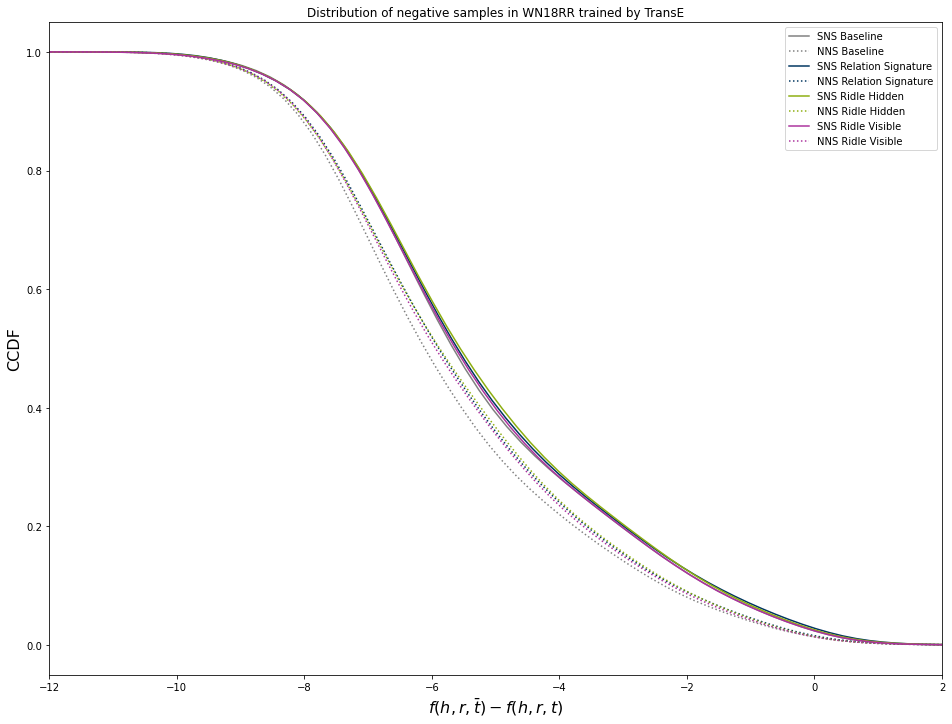

In [13]:
plt.figure(figsize=(16,12))
import sys
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = ['gray', '#003560', '#8DAE10', '#ac329d']
color_index = 0
for set in selected:
    sns, nns = [], []
    for f in glob(subexperiments[set]+"/NS_quality_analysis/*/*.npz"):
        minus_distances = dict(np.load(f))
        sns += list(minus_distances['sns'])
        nns += list(minus_distances['nns'])

    count_sns, bins_count_sns = np.histogram(sns, bins=100)
    count_nns, bins_count_nns = np.histogram(nns, bins=100)

    pdf_sns = count_sns / sum(count_sns)
    pdf_nns = count_nns / sum(count_nns)

    cdf_sns = np.cumsum(pdf_sns)
    cdf_nns = np.cumsum(pdf_nns)

    plt.plot(bins_count_sns[1:], 1-cdf_sns, label="SNS {}".format(legend[selected[color_index]]), color=colors[color_index])
    plt.plot(bins_count_nns[1:], 1-cdf_nns, label="NNS {}".format(legend[selected[color_index]]), color=colors[color_index], linestyle="dotted")

    plt.title(title)
    plt.legend()
    #plt.title(plot_title, fontsize=20)
    plt.xlabel(r"$f(h, r, \bar{t}) - f(h, r, t)$", fontsize=16)
    plt.ylabel("CCDF", fontsize=16)
    plt.xlim(-12,2)

    color_index += 1

    plt.savefig("Output/Plots/NS_quality_analysis/" + experiment_name)